# Introduction

Online consumers have almost unlimited shopping opportunities both in terms of products and merchands. E-commerce businesses, such as Olist, has to ensure that customers are highly satisfied when shopping on their platform, as the switching cost from Olist to another platform is insignificant for the individual consumer. One way that Olist can increase the shopping experience on the platform is to implement a recommendation system, which helps customers finding products they are looking for or would enjoy. These systems are called recommender systems and has been implemented broad success in a variety of different online platforms, such as Amazon, Netflix, etc. 

## KPI's

Recommender systems has become popular given the ability to create personalized recommendations, helping customers to make better decisions when shopping online. From a company's perspective, a recommender system can help increase sales, retain customers and increase the overall shopping experience. Therefore, implementing a recommender system would help Olist improve KPI's such as:
- Customer retention
- Average order value
- Customer satisfaction score
- Average weekly revenue (from phase 1) 

The current dataset does not enable us to measure the impact of a recommender system on the above mentioned KPI's, however, this would be relevant to assess in future analysis. 

## <font color='blue'>Setup 1</font>: Load Libraries

In [1]:
import pandas as pd
import numpy as np
import os
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline
from surprise import SVD
from surprise.dataset import Reader, Dataset
from surprise.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l2
from keras import backend as K
from keras.layers import Concatenate, Dense, Dropout
from keras.layers import Add, Activation, Lambda

Using TensorFlow backend.


## <font color='blue'>Setup 2</font>: Load data

In [2]:
#Loading all the data needed to create a recommender system
df_reviews = pd.read_csv("../data/olist_order_reviews_dataset.csv" ,sep=',')
df_orders = pd.read_csv("../data/olist_orders_dataset.csv" ,sep=',')
df_items = pd.read_csv("../data/olist_order_items_dataset.csv" ,sep=',')
df_products = pd.read_csv("../data/olist_products_dataset.csv" ,sep=',')
df_customer = pd.read_csv("../data/olist_customers_dataset.csv" ,sep=',')

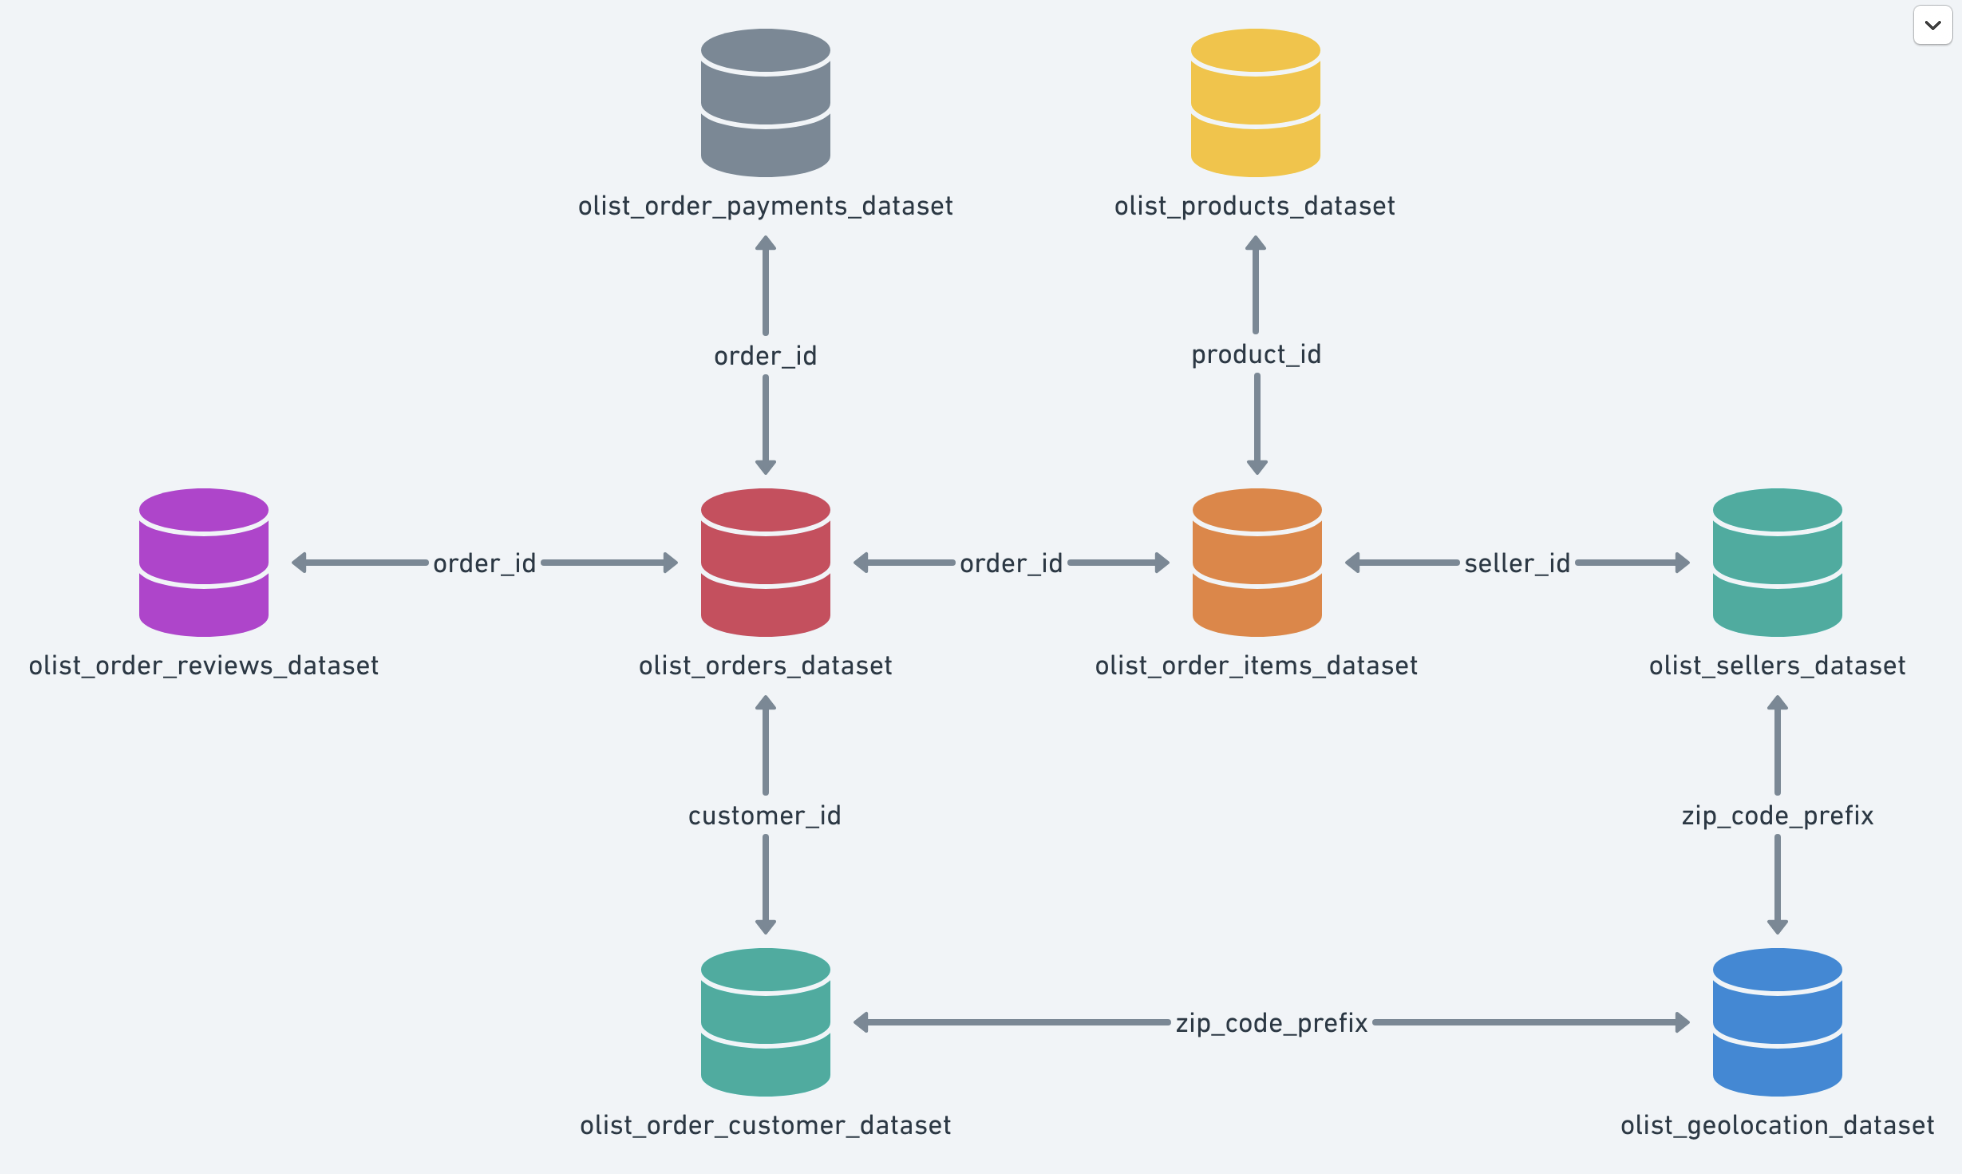

In [3]:
#Overview of the different data tables and how they are related
Image("data_tables.png")

## Recommender systems 

As briefly explained, recommender systems are very usefull for e-commerce businesses, streaming services, etc. Some businesses, however, are struggling to get the nesecarry datapoints. As Olist already holds the data nessecary to create a recommendation system, this could provide huge value for both their customer and Olist as a business. 

In this notebook, we chose to focus on three methods, which yields different performance and hence enables us to look at what the different users got recommended. Collaborative filering, and more specifically on item-to-item based collaborative filtering, is the first approach implemented. Secondly, we implement a SVD model to predict new reviews for customers. The SVD is compared to a baseline model in order to validate a significant improvement in the ability to predict reviews. Lastly, we are using a Feed Forward Neural Network to try and predict how a customer would review a given product not bought yet. 

Given our dataset and the features we have, we are not able to create a content-based filtering algorithm, as the algorithm would need more information. We would essentially need to know some specific attributes about every product, e.g. with movies we know whether they include themes such as: Baseball, Economics, etc. 
Furthermore, companies such as Amazon are using collaborative item-item based recommender systems (https://www.quora.com/What-algorithm-s-does-Amazon-use-in-their-recommendation-system), and this is also the one that makes most sense in our case, since we do not have a lot of information of about each individual. 

## 1. Data mapping: 

The information essentially needed, is a tables with customer ID's in rows and products in the columns, with reviews as values in the dataframe. This means that the three attributes; customers, reviews and products, are matched into one dataframe using 5 out of the 8 dataset visualised in the Setup 2 section. 

##### 1.1 Matching product ID's and product categories on the order items

In [4]:
#Printing an overview of the items table
df_items.describe(include="O")

,order_id,product_id,seller_id,shipping_limit_date
count,112650,112650,112650,112650
unique,98666,32951,3095,93318
top,8272b63d03f5f79c56e9e4120aec44ef,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,2018-03-01 02:50:48
freq,21,527,2033,21


In [5]:
#Printing an overview of the products table
df_products.describe(include="O")

,product_id,product_category_name
count,32951,32341
unique,32951,73
top,0b2a1288e8ba64c797e7586c8df75602,cama_mesa_banho
freq,1,3029


The overview of `df_items` reveals duplicate values of orderID's. This is because customers who are ordering several products in one order has the same `order_id` but a different `order_item_id`. 
The table `df_items` is enriched with the `product_id` and `product_category_name` for every item, such that we get an overview of all the order ID's, their corresponding order item ID and which product they bought. 

In [6]:
#Matching items and products to obtain the product category name:
ordered_products = df_items.merge(df_products, on="product_id", how= "left")

In [7]:
#Exclude irrelevant columns:
cols= ordered_products.columns
ordered_products = ordered_products[cols[0:8]]
ordered_products = ordered_products.drop(["shipping_limit_date", "price", "freight_value"], axis=1)

In [8]:
#Merged table with relevant columnsb
ordered_products.head()

,order_id,order_item_id,product_id,seller_id,product_category_name
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,pet_shop
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,moveis_decoracao
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,perfumaria
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,ferramentas_jardim


As seen in the above table, we now have what products what bought in which orders. This information should then be linked to which customer made the purchase and how satisfied they are with the product. 

##### 1.2 Matching the unique customer ID's with the orders

Both of the tables is assesed by their individual values. 

In [9]:
#Printing an overview of the customer table
df_customer.describe(include="O")

,customer_id,customer_unique_id,customer_city,customer_state
count,99441,99441,99441,99441
unique,99441,96096,4119,27
top,6624813688ccf41b6807e77a9f194c2b,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP
freq,1,17,15540,41746


In [10]:
#Printing an overview of the orders table
df_orders.describe(include="O")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,98875,90733,81018,95664,459
top,6568c925063764e35e36fa4a9b809937,6624813688ccf41b6807e77a9f194c2b,delivered,2017-11-20 10:59:08,2018-02-27 04:31:10,2018-05-09 15:48:00,2017-06-19 18:47:51,2017-12-20 00:00:00
freq,1,1,96478,3,9,47,3,522


This overview shows that there are as many `customer_id`'s as `order_id`'s, which indicates that Olist creates a customer ID for every order. The `df_customer` table also hold a `customer_unique_id` which maps the customer ID's to some unique customer ID's. This means, that the unique customer ID's are the ones we will look at in the recommender system.

In [11]:
print("Number of orders: ", len(df_orders), ". Number of customers: ", len(df_customer)\
      , ". Number of unique customers: ", df_customer.customer_unique_id.nunique())

Number of orders:  99441 . Number of customers:  99441 . Number of unique customers:  96096


As seen from the tables, there are less `customer_unique_id` than `customer_id`, which indicates that some customers have several `customer_id`'s. The unique customer ID's are now matched with all the `order_id`'s, such that every unique customers orders can be reviewd

In [12]:
# Unique customer ID's are matched witht the given order. The key is customer_id
unique_customer_orders = df_orders.merge(df_customer, on="customer_id", how= "left")

In [13]:
#And then we are only taking relevant columns:
cols = list(unique_customer_orders.columns[0:2])
cols.append("customer_unique_id")
unique_customer_orders = unique_customer_orders[cols]

In [14]:
#The table then looks like the following
unique_customer_orders.head()

,order_id,customer_id,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6


##### 1.3 Match reviews with every order. 

In [15]:
#Printing an overview of the reviws table
df_reviews.describe(include="O")

,review_id,order_id,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
count,100000,100000,11715,41753,100000,100000
unique,99173,99441,4600,36921,637,99010
top,0c76e7a547a531e7bf9f0b99cba071c1,df56136b8031ecd28e200bb18e6ddb2e,Recomendo,Muito bom,2017-12-19 00:00:00,2017-06-15 23:21:05
freq,3,3,426,230,466,4


As seen above, some `order_id`'s have multiple reviews. Looking at one of the order_id's with three reviews, we see the following data-points:

In [16]:
df_reviews[df_reviews.order_id=='8e17072ec97ce29f0e1f111e598b0c85']

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
45043,67c2557eb0bd72e3ece1e03477c9dff5,8e17072ec97ce29f0e1f111e598b0c85,1,NaN,Entregou o produto errado.,2018-04-07 00:00:00,2018-04-08 22:48:27
65024,2d6ac45f859465b5c185274a1c929637,8e17072ec97ce29f0e1f111e598b0c85,1,NaN,Comprei 3 unidades do produto vieram 2 unidade...,2018-04-07 00:00:00,2018-04-07 21:13:05
93027,6e4c4086d9611ae4cc0cc65a262751fe,8e17072ec97ce29f0e1f111e598b0c85,1,NaN,"Embora tenha entregue dentro do prazo, não env...",2018-04-14 00:00:00,2018-04-16 11:37:31


We have to filter these duplicate values out, such that we do not have several reviews for each order. The reason why this might be, is that one `order_id` can have several items. However, it is not possible to link the different `review_id`'s to the `order_item_id`, which means that we have to use assumptions. 

The approach is to use the aggregate mean for each order_id to calculate the score for that particular order. This might give the best result for the entire order and the different items in that order.

The review table looks like the following:

In [17]:
df_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [18]:
#Grouping by order_id and taking the mean for potential duplicate reviews for one order
reviews = df_reviews.groupby("order_id").mean().reset_index()

In [19]:
reviews.head()

,order_id,review_score
0,00010242fe8c5a6d1ba2dd792cb16214,5.0
1,00018f77f2f0320c557190d7a144bdd3,4.0
2,000229ec398224ef6ca0657da4fc703e,5.0
3,00024acbcdf0a6daa1e931b038114c75,4.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,5.0


And we can now match these reviews to every order and display the resulting table. The table `unique_orders` can be used to obtain the dataframe that we essentially need for creating the final dataset. 

In [20]:
unique_orders = unique_customer_orders.merge(reviews, on="order_id", how="left")

In [21]:
unique_orders.head()

,order_id,customer_id,customer_unique_id,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,4.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,4.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,5.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,5.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,5.0


##### 1.4 Orders and items can now be combined. 

As mentioned in section 1.3 it is assumed that each item in an order, is reviewed as the mean score for all items of that particular order. All the reviews are therefore merged in to all the items, such that we get a per-item review score for each product in an order. Explicitly, the number of orders ID's and unique order ID's are the following:

In [22]:
print("In the dataset we have", len(ordered_products), "order ID's and", len(unique_orders), "unique order ID's")

In the dataset we have 112650 order ID's and 99441 unique order ID's


The two datasets are merged such that all 112650 orders gets a review score

In [23]:
#Merging ordered_products and unique_orders 
item_review = ordered_products.merge(unique_orders, on="order_id", how="left")

and the final table is then displayed

In [24]:
item_review.head()

,order_id,order_item_id,product_id,seller_id,product_category_name,customer_id,customer_unique_id,review_score
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,cool_stuff,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,5.0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,pet_shop,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,4.0
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,moveis_decoracao,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,5.0
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,perfumaria,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,4.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,ferramentas_jardim,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,5.0


### 2. Creating a pivot table with customer and product ID's in rows and columns respectively

From the above item_review table, it is possible to make a table including per-customer and per-item reviews. However, a problem arise when trying to make a custumer-item-review table, since there are 32,951 unique products and 95,420 unique customers, which is too large to hold in memeory. Therefore, the number of purchases per product is sorted, and the products which has very few reviews are excluded. Arguably, products with a low amount of reviews might also be uncertain to recommend to others as their score is based on few reviews. 

In [25]:
print("As we have", len(item_review.customer_unique_id.unique()), "unique customers and", \
      len(item_review.product_id.unique()), "unique products, the resulting dataframe would be huge, and sparse..")

As we have 95420 unique customers and 32951 unique products, the resulting dataframe would be huge, and sparse..


In [26]:
#Creating a dataframe that contains how many reviews each product has
pp = item_review.groupby("product_id")["review_score"].count().sort_values()
ppdf = pd.DataFrame(pp)
ppdf.head()

,review_score
product_id,
00066f42aeeb9f3007548bb9d3f33c38,1
911e26785862f450cf2240fc5168f83d,1
911cfb37438b7fa9ad54535990178868,1
911b8d269dbaa6c005b23d04e1c7fcbc,1
9117307cf75efa6e964d697f0d1297f9,1


In [27]:
#Creating a dataframe which only contain products that has more than 10 reviews
ppdf_small = ppdf[ppdf.review_score>10]
len(ppdf_small)

1668

In [28]:
#Filtering the products with less than 10 reviews out if the main dataframe
products = list(ppdf_small.index)
item_review_s = item_review[item_review['product_id'].isin(products)]
len(item_review_s)

47676

The filtering gives a dataframe that has the following values:

In [29]:
print(len(item_review_s.customer_unique_id.unique()), "unique customers and", \
      len(item_review_s.product_id.unique()), "unique products. This is much better dimensions to work with. ")

41425 unique customers and 1668 unique products. This is much better dimensions to work with. 


Since some of the customers has bought the same products several times, these reviews has to be transformed in to one metric, to fit into the pivot table that is needed. Identical purchases from the same customer is thus averaged into one review score.

In [30]:
#Averaging identical purchases
item_review_ss = item_review_s.groupby(["customer_unique_id", "product_id"]).mean().reset_index()

In [31]:
#Creating a pivot table, which has unique customers in the rows, product id's in the columns and review score as
# values
dfr = item_review_ss.pivot(index= "customer_unique_id", columns= "product_id", values="review_score")
#dfr.shape

In [32]:
#Displaying the resulting data table holding all customer reviews for each item
dfr.head()

product_id,001b72dfd63e9833e8c02742adf472e3,00250175f79f584c14ab5cecd80553cd,005030ef108f58b46b78116f754d8d38,00878d953636afec00d3e85d55a12e7f,008cff0e5792219fae03e570f980b330,00ba6d766f0b1d7b78a5ce3e1e033263,00baba5b58e274d0332a0c8a0a66f877,00de7f393d962717eeeb2d7131a40dba,013ee64977aaa6b2b25475095162e0e9,014a8a503291921f7b004a5215bb3c36,...,fe9dfbe7f974621789683b7b78be2a16,fecf6223a3494f35362f670e571d2a04,fed5c40c27e1c88560a9e92d82ee0825,ff29d8cb1cd0cd5ea37b80dac9939e1c,ff2c1ec09b1bb340e84f0d6b21cc7dbb,ff5f8606556b625613f069a5a9a48966,ff7fccf8513f360157f0660fe51d1d88,ffa7e0cbe11656d11a117b534bb1db27,ffaf0af7eebb57c7f262b51ebb05dfd6,ffc9caf33e2d1e9f44e3e06da19085f7
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00053a61a98854899e70ed204dd4bafe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0005e1862207bf6ccc02e4228effd9a0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0005ef4cd20d2893f0d9fbd94d3c0d97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0006fdc98a402fceb4eb0ee528f6a8d4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3. Item-item based collaborative filtering

The item-item collaborative filtering was orginally proposed by Amazon, and is, in contrast to the user based collaborative filtering method, based on the similarity between items/products. In theory, the two methods should perform somewhat similar but in practice item-item collaborative filtering approaches often outperforms user-user based filtering. Item-item based collaborative filtering is a memeory-based collaborative filtering method, where we will later introduce a model-based collaborative filtering algorithm. 

The similarity between items is based on how many customers who bought item x also bought item y. If the correlation between two items is high a similarity is assumed, and we can thus recommend item y to customers who bought item x. 

The similarity measure is calculated by the following formula:

$$ r_{xi} = b_{xi} + \frac{\Sigma_{y \in \mathbf{K}}sim(x,y)(r_{yi}-b_{yi})}{\Sigma_{y \in \mathbf{K}}|sim(x,y)|}  $$

In the above formula, the first part of the equation is the baseline estimate for $r_{xi}$, and the second part the deviation from that baseline. The formula is implemented via a for-loop in later cells. 

At first, we start using an item-item based collaborative recommender system, where we can recommend different users products, that they have not consumed yet. Lets look at the top 10 products to recommend the first user in our dataset. 

In [33]:
#Recommending top ten products that fits best to the first customer in the dataset
customer = list(dfr.index)[0]
products = 10

In [34]:
#Calculating the correlation for between each item
correlations = dfr.corr()

##### Assessing correlation between products in a smaller subset

In [35]:
#Creating a dataframe that contains how many reviews each product has
data = item_review_s[["customer_unique_id","product_id", "review_score"]]
pp = data.groupby("product_id")["review_score"].count().sort_values()
ppdf = pd.DataFrame(pp)
ppdf.head()
#Creating a dataframe which only contain products that has more than 10 reviews
ppdf_small = ppdf[ppdf.review_score>200]
len(ppdf_small)
#Filtering the products with less than 10 reviews out if the main dataframe
products = list(ppdf_small.index)
item_review_sss = item_review[item_review['product_id'].isin(products)]
len(item_review_sss)
#Averaging identical purchases
item_review_sss = item_review_sss.groupby(["customer_unique_id", "product_id"]).mean().reset_index()
#Creating a pivot table, which has unique customers in the rows, product id's in the columns and review score as
# values
dfrr = item_review_sss.pivot(index= "customer_unique_id", columns= "product_id", values="review_score")

In [36]:
#Taking the correlation of the subset
corr_sub = dfrr.corr()

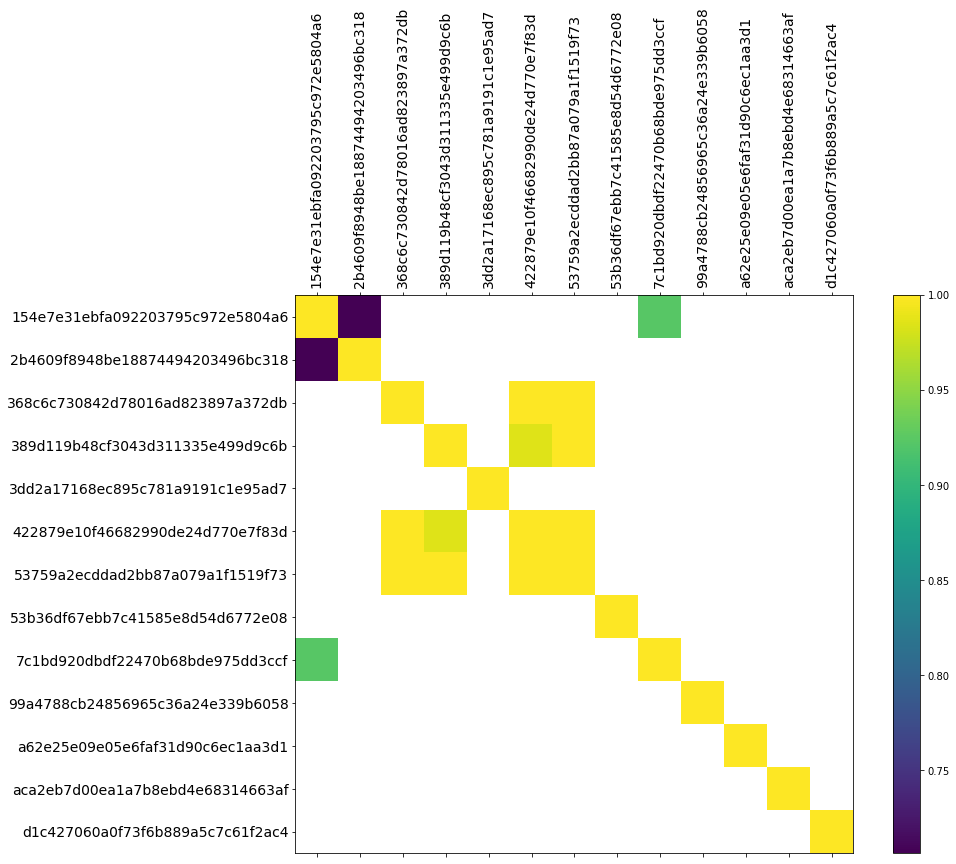

In [37]:
#Plotting the correlation between the most reviewed products
f = plt.figure(figsize=(14, 10))
plt.matshow(corr_sub, fignum=f.number)
plt.xticks(range(corr_sub.shape[1]), corr_sub.columns, fontsize=14, rotation=90)
plt.yticks(range(corr_sub.shape[1]), corr_sub.columns, fontsize=14)
#plt.savefig('corr.png', bbox_inches='tight')
cb = plt.colorbar()

This plot gives us two subconclusions. First, we are able to obtain correlation between some of the most reviewed products. However, there are also many of the products that does not have any correlation with other products because Olists customers does not purchase many different products. 

We will now proceed with the larger dataset, `dfr`, defined in the end of last section. 

In [38]:
#Recommending top ten products that fits best to the first customer in the dataset
customer = list(dfr.index)[0]
products = 10

In [49]:
#Finding products that the customer has not yet purchased
_purchased = dfr.loc[customer]
_purchased = _purchased[_purchased.isnull()]
#Showing some of the unrated products
_purchased.head()

product_id
001b72dfd63e9833e8c02742adf472e3   NaN
00250175f79f584c14ab5cecd80553cd   NaN
005030ef108f58b46b78116f754d8d38   NaN
00878d953636afec00d3e85d55a12e7f   NaN
008cff0e5792219fae03e570f980b330   NaN
Name: 0000366f3b9a7992bf8c76cfdf3221e2, dtype: float64

In [50]:
#Calculating the similarity between different items, and thus recommending the products with highest similarity
for product, review in _purchased.iteritems():
    rating = 0
    weights_sum = 0
    neighbours_corr = correlations[product].sort_values(ascending=False)[1: products+1]
    item_mean = dfr[product].mean()
    neighbours_ratings = dfr[neighbours_corr.index].transpose()
    neighbours_means = neighbours_ratings.mean(axis=1)
    for neighbour_id, row in neighbours_ratings.iterrows():
        if np.isnan(row[customer]): continue
        rating += neighbours_corr[neighbour_id] * (row[customer] - neighbours_means[neighbour_id])
        weights_sum += abs(neighbours_corr[neighbour_id])
    if weights_sum > 0:
        rating /= weights_sum
    print(rating)
    rating += item_mean
    print(rating)
    _purchased.at[product] = rating

0
3.75
0
4.142857142857143
0
4.615384615384615
0
4.090909090909091
0
4.4
0
4.181818181818182
0
4.166666666666667
0
3.0
0
4.214285714285714
0
4.111111111111111
0
3.939655172413793
0
4.526315789473684
0
3.4166666666666665
0
4.2
0
3.5384615384615383
0
4.0
0
3.9210526315789473
0
3.238095238095238
0
4.642857142857143
0
3.8
0
3.6666666666666665
0
4.0
0
5.0
0
3.933333333333333
0
3.8
0
3.75
0
4.1
0
4.2727272727272725
0
4.380952380952381
0
3.7142857142857144
0
4.142857142857143
0
4.333333333333333
0
4.212121212121212
0
4.53125
0
4.24
0
3.5
0
4.0
0
4.190476190476191
0
4.2727272727272725
0
4.421052631578948
0
4.0
0
4.071428571428571
0
4.363636363636363
0
3.9310344827586206
0
4.333333333333333
0
4.125
0
4.7
0
4.151515151515152
0
3.607142857142857
0
3.6470588235294117
0
4.333333333333333
0
4.030927835051546
0
3.782608695652174
0
4.055555555555555
0
4.142857142857143
0
2.8125
0
4.071428571428571
0
4.0
0
4.454545454545454
0
4.071428571428571
0
4.0
0
4.125
0
4.769230769230769
0
3.5346534653465347
0
4.

0
3.227272727272727
0
3.9375
0
3.923076923076923
0
3.7
0
4.157894736842105
0
3.6153846153846154
0
3.6666666666666665
0
4.514285714285714
0
3.9575971731448765
0
4.218371837183718
0
3.6666666666666665
0
3.586206896551724
0
4.0
0
4.386666666666667
0
4.041666666666667
0
3.9
0
3.357142857142857
0
4.454545454545454
0
4.833333333333333
0
2.857142857142857
0
4.350877192982456
0
3.526315789473684
0
3.5
0
3.409090909090909
0
4.405405405405405
0
4.25
0
4.714285714285714
0
4.484848484848484
0
4.166666666666667
0
4.909090909090909
0
3.86046511627907
0
3.5
0
4.0344827586206895
0
2.6666666666666665
0
4.111111111111111
0
4.826086956521739
0
3.7857142857142856
0
4.627906976744186
0
3.526315789473684
0
4.636363636363637
0
4.25
0
4.052631578947368
0
3.9166666666666665
0
4.583333333333333
0
4.315789473684211
0
3.5
0
3.1
0
3.923076923076923
0
4.333333333333333
0
4.074074074074074
0
3.769230769230769
0
4.4393939393939394
0
4.583333333333333
0
4.6923076923076925
0
5.0
0
3.857142857142857
0
3.625
0
3.5625
0
3

0
4.380952380952381
0
4.6
0
4.097560975609756
0
4.125
0
4.365853658536586
0
4.818181818181818
0
3.75
0
3.4523809523809526
0
4.555555555555555
0
4.333333333333333
0
2.5
0
4.142857142857143
0
4.538461538461538
0
3.8
0
3.5
0
4.1390532544378695
0
4.111111111111111
0
3.5
0
3.5833333333333335
0
3.3076923076923075
0
4.142857142857143
0
4.2105263157894735
0
4.333333333333333
0
4.090909090909091
0
4.7272727272727275
0
4.303030303030303
0
4.173913043478261
0
3.923076923076923
0
4.25
0
4.066666666666666
0
4.5
0
4.09375
0
3.0833333333333335
0
3.8037974683544302
0
3.325
0
4.208333333333333
0
4.553191489361702
0
3.3636363636363638
0
4.222222222222222
0
3.78125
0
4.352941176470588
0
3.8484848484848486
0
4.65
0
4.166666666666667
0
3.5714285714285716
0
4.375
0
3.75
0
4.066666666666666
0
3.869565217391304
0
4.241379310344827
0
4.2592592592592595
0
3.8333333333333335
0
4.615384615384615
0
4.090697674418605
0
4.045454545454546
0
4.083333333333333
0
3.8823529411764706
0
3.923076923076923
0
4.08333333333333

0
4.066666666666666
0
4.25
0
3.6666666666666665
0
4.166666666666667
0
4.454545454545454
0
3.9473684210526314
0
4.066666666666666
0
3.2222222222222223
0
4.24
0
4.125
0
4.39344262295082
0
4.4
0
4.344827586206897
0
4.3
0
3.142857142857143
0
4.529411764705882
0
4.105263157894737
0
4.75
0
4.532258064516129
0
4.9
0
4.590909090909091
0
4.7
0
4.428571428571429
0
4.814814814814815
0
3.5
0
4.068181818181818
0
4.235294117647059
0
4.65
0
3.9166666666666665
0
4.416666666666667
0
4.690476190476191
0
3.6
0
4.291666666666667
0
1.75
0
4.645833333333333
0
4.615384615384615
0
4.3
0
4.2727272727272725
0
4.583333333333333
0
3.8666666666666667
0
4.090909090909091
0
4.090909090909091
0
4.157894736842105
0
4.25
0
4.181818181818182
0
4.3125
0
4.076923076923077
0
2.7916666666666665
0
4.090909090909091
0
4.170731707317073
0
3.6153846153846154
0
4.190476190476191
0
4.470588235294118
0
4.636363636363637
0
4.0701754385964914
0
4.666666666666667
0
4.785714285714286
0
3.75
0
4.3584905660377355
0
4.133333333333334
0
4

In [42]:
#Top 10 recommended products for the customer 
_purchased.sort_values(ascending=False)[0:products]

product_id
03e1c946c0ddfc58724ff262aef08dff    5.0
143c616ec3fe0cb065c3805cf9bd812e    5.0
6ee7217ab647f3c2b4a5161c75cadab3    5.0
2722b7e5f68e776d18fe901638034e54    5.0
59c1840441f4df065f52760bf51a8442    5.0
37eb69aca8718e843d897aa7b82f462d    5.0
8173ca41cdb176462f9ae79821a48404    5.0
2ced45a3059cbb128a8b8b6508809746    5.0
8b6ed41158b194711f83b8da92757544    5.0
16ce899c7af0c99f46948734a0d00f0f    5.0
Name: 0000366f3b9a7992bf8c76cfdf3221e2, dtype: float64

It is also possible to look at which product categories we are recommending the user, which gives some more context to the prediction. 

In [ ]:
rec_cat = item_review_s[item_review_s["product_id"].isin(list(pd.DataFrame(_purchased.sort_values(ascending=False)\
                        [0:products]).index))].product_category_name.unique()

In [ ]:
#Displaying recommended categories:
list(rec_cat)

Apparently, some of the products is within the same product category, since we only get eight different categories. 

The item-item based collaborative filering approach shows that we are able to recommend products to a customer, that has not purchased the specific product before. Given the similarity between two products, we are able to tell which other products the customer might find interesting. We are not able to directly measure the accuracy or error of the item-item based approach, as we have not split the data into test and train. One of the good things about this approach, is that it works for any product and we do not need specific features. The item-item also has some downsides. One of them is sparsity in the user-ratings matrix. 

### 4. Latent Factor Model

Since an item-item based collaborative filtering approach is relatively simple we are building a more complex recommender system, using a Latent Factor Model (LFM). The LFM is a model-based collaborative filtering method, which in contrast to the memory-based method is not just focussed around the neighbouring products or items. 

It uses the Singular Value Decomposition algorithm to optimize performance, essentially turning the recommendation into an optimization problem. We are still looking for similarity between items though. Mathematically, the matrix factorization which we later optimize looks like the following:

$$ \hat{X} = U\Sigma V^\intercal$$

The utility matrix, X, is essentially what we would like optimized and this happends through the SVD. The matrices, $U$, $\Sigma$, and $V$ are the inputs in the SVD algorithm, as we are decreasing dimensionality by finding latent factors. This happens through:

$$ \min_{U,\Sigma,V} \Sigma_{i,j} \left( d_{ij} - [U\Sigma V^\intercal] \right) $$

In the following, we are running a LFM.

In [ ]:
#Sorting out the data needed
data = item_review_s[["customer_unique_id","product_id", "review_score"]]

In [ ]:
print("The shape of the dataframe is: ", data.shape, " and the data includes", \
      len(data.groupby(["customer_unique_id"]).count()), " unique customers")

As we have so many unique customers we will take a small subset, and only look at the customers who has made at least four purchases. This will dramatically reduce the size of the dataset, but it might also make the predictions of higher quality, as we will have more data on each customer.

In [ ]:
#Creating a dataframe that will contain how many products each customer has purchased
pp = data.groupby("customer_unique_id")["product_id"].count().sort_values()
ppdf = pd.DataFrame(pp)
ppdf.head()

In [ ]:
#Creating a dataframe which only contains customers who has purchased more than 3 items
ppdf_small = ppdf[ppdf.product_id>3]
len(ppdf_small)

In [ ]:
#Filtering the customers with less than 3 purchases out if the main dataframe
products = list(ppdf_small.index)
data = data[data['customer_unique_id'].isin(products)]
len(data)

Our dataset is now dramatically reduced into a length of 2154. We are now resetting the index and splitting itinto test and training data:

In [ ]:
#Resetting index
data = data.reset_index()
data = data.drop(["index"],axis=1)

In [ ]:
#Splitting the data into test/train by a 70% split
train_ind, test_ind = [], []
#
for i, product_id in enumerate(data['product_id'].unique()):
    rows = data[data['product_id'] == product_id]
    ind = rows.index[:2].values.tolist()
    train_ind += ind

c = 0.7
b = len(train_ind) / len(data)
a = (c - b) / (1 - b)
print(a)

In [ ]:
#Creating the splits:
all_ind = set(range(len(data)))
not_used = list(all_ind - set(train_ind))

not_done = True
np.random.seed(42)
while not_done:
    np.random.shuffle(not_used)
    train_ind_ = train_ind + not_used[:int(a * len(not_used))]
    df_train = data.loc[train_ind_]
    if data.nunique()['product_id'] == df_train.nunique()['product_id'] and data.nunique()['customer_unique_id'] == df_train.nunique()['customer_unique_id']:
        not_done = False
        train_ind = train_ind_

test_ind = list(all_ind - set(train_ind))
train_ind = sorted(train_ind)
test_ind = sorted(test_ind)
print(len(train_ind)/len(all_ind))
print(len(test_ind)/len(all_ind))

In [ ]:
#Saving the data for future runs since it takes quite a while to split the data
np.savetxt('data/recommender_data_train.csv', train_ind, fmt="%d")
np.savetxt('data/recommender_data_test.csv', test_ind, fmt="%d")

#If we need to assess the data again later, we can run the code below
#train_ind = np.loadtxt('data/data_train.csv', dtype=int)
#test_ind = np.loadtxt('data/data_test.csv', dtype=int)

In [ ]:
#Defining the train and test data from the split made above
df_train = data.iloc[train_ind]
df_test = data.iloc[test_ind]

In [ ]:
#Defining helper functions to calculate RMSE and create a boxplot for later exploraiton of the precision of the model
def RMSE(y_true, y_pred):
    return np.linalg.norm(y_true - y_pred) / np.sqrt(len(y_true))

def MakeBoxplot(y_true, y_pred, title):
    data = [y_pred[y_true == (x*0.5+0.5)] for x in range(10)]
    fig = plt.figure(figsize=(5, 5))
    plt.boxplot(data)
    min_a, max_a = 0., 5.5
    plt.xlim((min_a, max_a))
    plt.ylim((min_a, max_a))
    plt.plot([min_a, max_a * 2], [min_a, max_a], ls='--', color='gray', linewidth=1.0)
    plt.xticks(range(12), [x*0.5 for x in range(12)])
    plt.xlabel('True Rating')
    plt.ylabel('Predicted Rating')
    plt.title(title)
    plt.show()

In [ ]:
#Defining y_true from the test data
y_true = df_test['review_score'].values

##### Dummy baseline 

As a start, we are creating a dummy baseline, which predicts the mean of all the reviews as a prediction for every review unknown to the model.

In [ ]:
#Using the global mean of all the training reviews as prediction for the unknown test datapoints. 
global_mean = df_train['review_score'].mean()
print("global_mean =", global_mean)

In [ ]:
#Using the variable global_mean as prediction
y_pred = []
for i, row in df_test.iterrows():
    y_pred.append(global_mean)
y_pred = np.array(y_pred)

In [ ]:
#Calculating the performance of the model
error = RMSE(y_true, y_pred)
print("RMSE =", error)
MakeBoxplot(y_true, y_pred, 'Test Set')

Using the average rating as a review prediction for all other products does not intuitively seems like a good idea but it gives us a basline. We are then working from the hypothesis that we can improve this recommendation substantially via more complex models, that are learning from the data. In the rest of this notebook, we are using two other, more complex, models to improve the RMSE. 

##### Beating the baseline model

As the average review for all products might be a bad estimate for how a given customer might rate some product, we will try to beat this baseline. For this purpose, an SVD model is implemented to predict ratings of unrated products for customers. This will hopefully beat the baseline model but also provide better recommendations than the item-item based collaborative filtering model although results from the SVD can not be directly compared to the predictions of the item-item based recommendation system. 

To improve the SVD model we are using grid search for hyperparamteter tuning. In the next cells we are using the surprise package to transform data into the correct format and to run the model. 

In [ ]:
#Defining the rating scale (from 1 to 5) and loading our dataset from a pandas dataframe. 
reader = Reader(rating_scale=(1, 5.0))
data_surprise = Dataset.load_from_df(df_train, reader)

In [ ]:
#Using grid search to tune the hyperparameters of the model. Note also, that we are using 5 cross validations. 
param_grid = {
    'n_epochs': [5, 10, 20], 
    'lr_all': [0.005, 0.05, 0.01],
    'reg_all': [0.001, 0.01, 0.1], 
    'n_factors': [10, 25, 50, 100],
    'biased': [True, False]
}

#Creating the grid and conducting grid-search
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
gs.fit(data_surprise)

#Printing the best RMSE score and the best hyperparameters: 
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

In [ ]:
#We define the model, as the one having the best RMSE
model = gs.best_estimator['rmse']
model.fit(data_surprise.build_full_trainset());

In [ ]:
#Defining the test values for customer and product ID's
customer_ids_true = df_test['customer_unique_id'].values
product_ids_true = df_test['product_id'].values

In [ ]:
#Predicting customer values: 
y_pred = []
for customer_id, product_id in zip(customer_ids_true, product_ids_true):
    r = model.predict(customer_id, product_id, verbose=False).est
    y_pred.append(r)
y_pred = np.array(y_pred)

In [ ]:
#Calculating the error and plotting the results
error = RMSE(y_true, y_pred)
print("RMSE =", error)
MakeBoxplot(y_true, y_pred, 'Test Set')

As we see on the RMSE the SVD model significantly improved the performance in predicting recommendations for customers in comparison to the baseline model. This ensure that we can help Olist provide some valuable knowledge about which products customers would potentially like and dislike, given other products they have previously bought. The RMSE score for the SVD model is 0.5 compared to 1.66 in the baseline model. SVD handles matrix sparsity very well, which is a pro for using this model. A drawback on the SVD is the missing explanation for why a certain product was recommended to a given customer. 

Even though we have a fairly good model compared to the baseline, we are trying to create a model that might detect a signal for even better recommendations. 

### 5. Trying to beat the LFM with a Feed Forward Neural Network

In this part of the notebook, we will try to include a feed forward neural network (FFNN) to predict reviews for customers. This model can be directly compared to the SVD model, given that we are using Root Mean Squared Error as a metric for the models performance. 

The same dataset as in the SVD model is used, hence we are still looking at customers who has purchased more than three products. 

We are using a label encoder to transform the `customer_unique_id` and `product_id` into sequential numbers, so that we can later use this as input to the FFNN. The data is therefore still the same but the original ID's provided in the dataset are encoded. We are also ensuring that the review score are a float type numeric value. 

In [ ]:
#Turning the customers and the products into a sequential number starting from 0.
customer_enc = LabelEncoder()
data['customer'] = customer_enc.fit_transform(data['customer_unique_id'].values)
n_customers = data['customer'].nunique()
item_enc = LabelEncoder()
data['product'] = item_enc.fit_transform(data['product_id'].values)
n_products = data['product'].nunique()
data['review_score'] = data['review_score'].values.astype(np.float32)
min_review_score = min(data['review_score'])
max_review_score = max(data['review_score'])
print("Number of customers, products, their min review_score and max review_score: ", n_customers, n_products, \
      min_review_score, max_review_score)

Then we split the data into test and training data. This is the same split (70/30) as in the example above. This way, we can directly compare the model performance to the SVD model. 

In [ ]:
#Splitting the data into test and trining data 
X = data[['customer', 'product']].values
y = data['review_score'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

We now have have a test and training dataset which has the same split as in the SVD model. As can be seen, there are 1507 training points and 647 test points, exactly the same amount as we had in the SVD model. 

For the neural network we are using a factor of 50. It can be essentially any number, however 50 was the most appropriate for this model, as it revealed the best result. 

In [ ]:
#Deciding on the number of factors that are essentially the embedding layer 
n_factors = 50
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

##### The model:

The FFNN we are using to predict a customers review for a product consists of the following:

- An embedding layer, where we are embedding both the user and the product into a vector of size 50. The model will essentially learn from these parameters, so that the rating prediction of a certain product for a given customer, is based on the concatenated user-vector and product-vector. 
- The two embeddings are concatenated and inputted into the model.
- A dropout layer with a value of 0.1 is used on the concatnated user and product matrices. 
- A dense layer with a relu activation function Kaiming He weight-initialisation and 200 neurons. 
- A dropout layer which sets 50% of the networks weights to zero. 
- A dense output layer, which outputs a single value. This prediction is ran through a sigmoid activation function and scaled so that it is between the lowest possible rating and higest possible rating. 

The network thus has one layer with an input size of 100, a hidden layer of 200 neurons, and an output layer of 1. We are using the Adam optimizer and the root mean squared error function as loss. 

In [ ]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [ ]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors)(x)
        x = Reshape((self.n_factors,))(x)
        return x
    
def RecNet(n_customers, n_products, n_factors, min_review_score, max_review_score):
    customer = Input(shape=(1,))
    u = EmbeddingLayer(n_customers, n_factors)(customer)
    
    product = Input(shape=(1,))
    m = EmbeddingLayer(n_products, n_factors)(product)
    
    x = Concatenate()([u, m])
    x = Dropout(0.1)(x)
    
    x = Dense(200, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_review_score - min_review_score) + min_review_score)(x)
    model = Model(inputs=[customer, product], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss=root_mean_squared_error, optimizer=opt)
    return model

In [ ]:
model = RecNet(n_customers, n_products, n_factors, min_review_score, max_review_score)
model.summary()

In [ ]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=15,
                    verbose=1, validation_data=(X_test_array, y_test))

In [ ]:
print("The RMSE of the FFNN model after 15th epoch is:", history.history["val_loss"][-1])

The FFNN model is giving almost the exact same result as the SVD model after training for 15 epochs. There are both pros and cons for using both models given that one of them does not outperform the other. One of the pros using a FFNN is that we can use other attributes as input as well. As the model are embedding the user and product into embeddings and concatenating these vectors, we could easily add more information into this vector. This approach might be able to increase performance even more. One of the drawbacks, however, using a FFNN is the inability to say why the model is predicting as it does, making the prediction kind of a black box. This is kind of similar to the drawback on the LFM, as discussed above. 

# Conclusion

The hypothesis throughout this phase of the project has been to prove that Olist can benefit from using recommender systems in the online operations. Given that no other information is provided, we assume that no such system is in production today, which is why valuable recommendations to customers could help increase important KPI's for Olist. 

In the introduction we primarily discussed the imporance of recommender systems and touched upon three KPI's that Olist should pay attention to if a recommender system was implemented. The exploration of current purchasing data gave insights into how and which type of recommender system might be the most appropriate. There are, however, several benefits and drawbacks with each distinct system besides the individual model performance. 

At first, all the needed datasets was combined to hold the correct attributes needed to create a recommender system. This involed combining 5 of the total 8 data tables using relevant keys to obtain a final dataset, which held information about the product purchased by the user, and how good/bad the user had rated the product. 

Memory based collaborative filtering methods, such as item-item based models, are quite simple and easy for testing different hypothesis, which is why we implemented more complex model based collaborative filtering models. In the latter part of the notebook, we constructed a baseline model that gave the average product rating over all products as a review prediction for a given customer on a specific product. We then proceeded to use more sophisticated models, namely a Latent Factor Model and a Feed Forward Neural Network. All performance metrics are the Root Mean Squared Error and the is presented in the table below.

| Baseline (global mean of reviews) | LFM using SVD | FFNN |
| --- | --- | --- |
| 1.66 | 0.5 | 0.51 |

The overall recommendation is to use the item-item based recommender system as a start and carefully monitor the KPI's to see if the initiative indicates an increased business value given the relevant KPI's. While the hypothesis about recommender systems can add value to Olist's customers, we also recommend looking into classification models predicting ratings. Since Olist currently only has 5 distinct reviews ,[1, 2, 3, 4, 5], it is a well suited classification problem to predict customer reviews. One of the main arguments is that classification models lets us optimize for false negatives, i.e. we do not want to miss the chance of recommending a product that a customer would have liked if they were exploided to it. This is something that could be build into a cost function of e.g. a FFNN. Lastly, a general problem is that the data quality is not that high as customers does not purchase many product and neither many distinct products. 